# Problem Set 4, due '05/23/2017' at 3:30pm.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 3.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import time

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [3]:
# uncomment the following if you want to see a lengthy description of the dataset
print("keys:", bdata.keys())
print("feature names:",  bdata.feature_names)
print("data shape:", bdata.data.shape)
print("target shape", bdata.target.shape)
#print(bdata.DESCR)
print("-"*100)

# Create a DataFrame that contains 13 features and target
df_data = pd.DataFrame(bdata.data, columns = bdata.feature_names)
df_data['MEDV'] = bdata.target
#df_data

# (a) regressing the housing price on the number of rooms per house
lm1 = smf.ols('MEDV ~ RM', df_data).fit()
print(lm1.summary())
print("-"*100)

# (b) regressing the housing price on the number of rooms per house and the squared
df_data['RM2'] = df_data['RM'] ** 2
lm2 = smf.ols('MEDV ~ RM + RM2', df_data).fit()
print(lm2.summary())


keys: dict_keys(['data', 'target', 'feature_names', 'DESCR'])
feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
data shape: (506, 13)
target shape (506,)
----------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 22 May 2017   Prob (F-statistic):           2.49e-74
Time:                        17:36:59   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                        

**Interpretation**:

**linear regression (a):** the coefficient of RM is 9.1 with an intercept of -34.67. The negative intercept value doesn't logically make sense, and the coefficient means that with one unit increase of the number of rooms per house, we will observe 9.1 unit increase of the median house price (in $1,000s). The p-value is below 0.05, indicating that there exists a significant relationship between two variables.

**linear regression (b):** the coefficient of RM and RM-Squared is -22.64 and 2.47 respectively, with an intercept of 66. The coefficient value of RM changed from positive to negative due to the impact of RM-Squared variable, and the overall intercept also changed from negative to positive and has higher magnitude. In addition, the standard error in model b is bigger than model a, which indicates that a higher level of multicollinearity in linear regression model will make lower accuary and make coefficients less significant.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 250-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house.
Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 250 slope coefficients, and draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

Note: please use 'random_state=1' and keep 'shuffle=False' when doing the KFold splitting to ensure reproducibility!

/Users/Amit/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


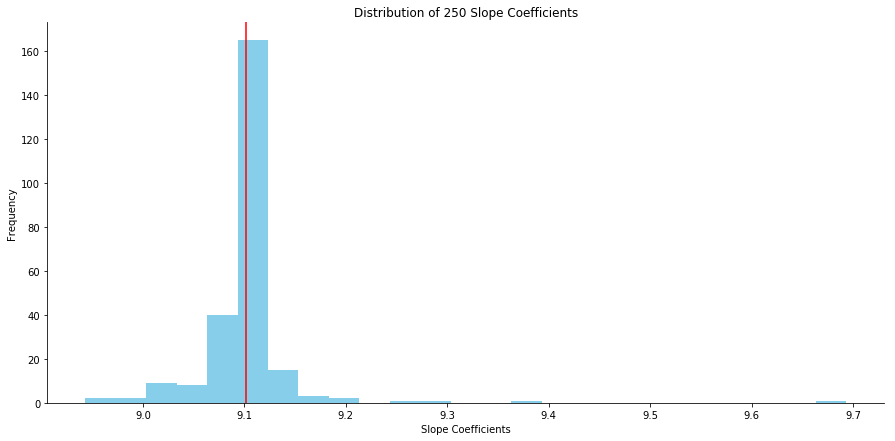

In [4]:
from sklearn.cross_validation import KFold

# create an empty list to store coefficient values
coef_list = []
lm = sklearn.linear_model.LinearRegression()
X = df_data['RM']
Y = df_data['MEDV']

# use 250-fold cross-validation to fit regression (a) above
kf = KFold(len(df_data), 250, shuffle = False, random_state = 1)
for train, test in kf:
    X_train = X[train].values.reshape(-1, 1)
    Y_train = Y[train].values.reshape(-1, 1)
    coef = lm.fit(X_train, Y_train)
    coef_list.append(coef.coef_[0][0])

# plot the distribution of the 250 slope coefficients
plt.figure(figsize = (15, 7))
hist = plt.subplot(111)
hist.hist(coef_list, bins = 25, color='skyblue')
hist.spines['right'].set_visible(False)
hist.spines['top'].set_visible(False)
hist.yaxis.set_ticks_position('left')
hist.xaxis.set_ticks_position('bottom')

plt.xlabel('Slope Coefficients')
plt.ylabel('Frequency')
plt.title('Distribution of 250 Slope Coefficients')

# draw a vertical line at the value of the slope coefficient estimated in 1.1
plt.axvline(9.1021, color='red')
plt.show()

**Interpretation:**

From the histogram above, we observe that the majority of slope coefficients (about 165 observations) fall between 9.1 and 9.125, and after drawing the vertical line, we find that the coefficient 9.1021 which is estimated in 1.1 also falls in this frequency range. Therefore the 250-fold cross validation proves that our linear regression model provided an accurate slope coefficient of the RM variable.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

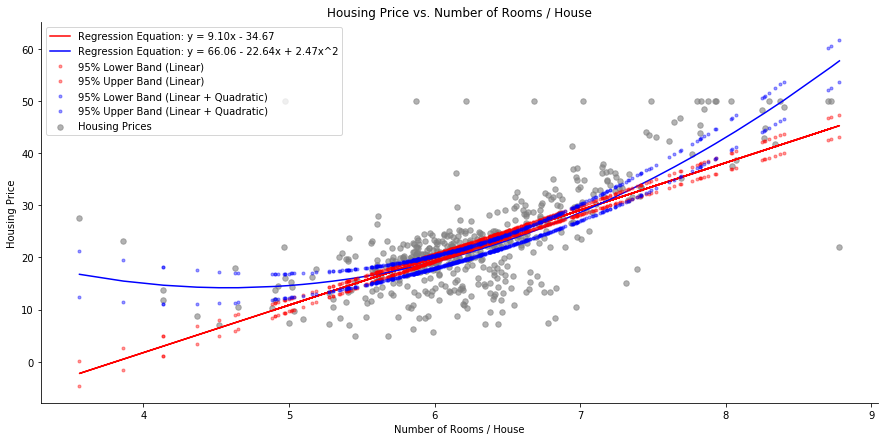

In [5]:
plt.figure(figsize = (15, 7))
scat = plt.subplot(111)

# Generate the scatter plot: RM vs. MEDV
scat.scatter(df_data.RM, df_data.MEDV, s = 30, color = 'grey', alpha = 0.6, label = 'Housing Prices')

# Calculate confidence intervals for the first regression
Y1 = lm1.params[1] * X + lm1.params[0]
resid = Y - Y1
mean_x1 = np.mean(X)
n = len(X)
t = 1.96
sq_er = np.sum(np.power(resid,2)) 
CI = t * np.sqrt((sq_er/(n - 2))*(1.0 / n + (np.power((X - mean_x1), 2) / ((np.sum(np.power(X, 2)))-n*(np.power(mean_x1, 2))))))

# Calculate confidence intervals for the second regression
X_sort = np.sort(X)
Y2 = lm2.params[2] * (X_sort**2) + lm2.params[1] * X_sort + lm2.params[0]
resid2 = Y - Y2   # residuals
mean_x2 = np.mean(X_sort)
sq_er2 = np.sum(np.power(resid2,2))
CI2 = t * np.sqrt((sq_er2/(n-2))*(1.0/n + (np.power((X_sort-mean_x2),2) / ((np.sum(np.power(X_sort,2)))-n*(np.power(mean_x2,2))))))

# Calculate the lower bands and upper bands for 2 regressions
lw = Y1 - abs(CI)
up = Y1 + abs(CI)
lw2 = Y2 - abs(CI2)
up2 = Y2 + abs(CI2)

# Show the first linear regression line in red, and label it
plt.plot(X, Y1, color = 'red', label = 'Regression Equation: y = 9.10x - 34.67')

# Show the second linear + quadratic regression line (which may have curvature) in blue, and label it
plt.plot(X_sort, Y2, color = 'blue', label='Regression Equation: y = 66.06 - 22.64x + 2.47x^2')

# plot the first 95% confidence bands in red (.) 
plt.plot(X, lw, 'r.', label = '95% Lower Band (Linear)', alpha = 0.4)
plt.plot(X, up, 'r.', label = '95% Upper Band (Linear)', alpha = 0.4)

# plot the second 95% confidence bands in blue (.)
plt.plot(X_sort, lw2, 'b.', label='95% Lower Band (Linear + Quadratic)', alpha = 0.4)
plt.plot(X_sort, up2, 'b.', label='95% Upper Band (Linear + Quadratic)', alpha = 0.4)

# format the plot
plt.legend(loc = 'upper left')
scat.spines['right'].set_visible(False)
scat.spines['top'].set_visible(False)
scat.yaxis.set_ticks_position('left')
scat.xaxis.set_ticks_position('bottom')

plt.xlabel('Number of Rooms / House')
plt.ylabel('Housing Price')
plt.title('Housing Price vs. Number of Rooms / House')

plt.show()


## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: It is always useful to include maximum number of iterations, otherwise a rogue estimation may go on forever.*

In [6]:
"""
    Function
    --------
    bivariate_ols: Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

    Parameters
    ----------
    xvalues, yvalues : narray xvalues: independent variable; yvalues: dependent variable
    R: float, Learning rate
    MaxIterations: Int, maximum number of iterations

    Returns
    -------
    alpha: float, intercept
    beta: float, co-efficient
    ttaken: time taken
    it: number of iterations
    convergence: logical, convergence achieved?
"""
def bivariate_ols(xvalues, yvalues, R, MaxIterations):
    # initialize necessary parameters
    alpha = 10
    beta = 10
    it = 0
    convergence = False
    err = alpha + beta * xvalues - yvalues
    n = len(xvalues)
    J = (1.0 / 2*n) * np.dot(err, err)
    epsilon = 0.0001
    grad_a = (1.0 / n) * err.sum()
    grad_b = (1.0 / n) * np.dot(err, xvalues)
    
    # counting time
    time1 = time.time()
    
    # begin iteration
    while True:
        if it == MaxIterations:
            print('Maximum number of iterations reached.')
            break
        
        alpha -= R * grad_a
        beta -= R * grad_b
        err1 = alpha + beta * xvalues - yvalues
        J1 = (1.0 / 2*n) * np.dot(err1, err1)
        if abs(J1 - J) <= epsilon:
            convergence = True
            break
        
        grad_a = (1.0 / n) * err1.sum()
        grad_b = (1.0 / n) * np.dot(err1, xvalues)
        J = J1
        it += 1
    
    # stop counting time
    ttaken = round(time.time() - time1, 2)
    
    # return the 5 wanted values
    return round(alpha, 2), round(beta, 2), ttaken, it, convergence

In [27]:
# choose RM and MEDV as x and y values
xvalues = bdata.data[:, 5]
yvalues = bdata.target[:]

# Experiment with 3-4 different values of the learning rate R
print('R = 0.005:')
print(bivariate_ols(xvalues, yvalues, 0.005, 100000),'\n')
print('R = 0.02:')
print(bivariate_ols(xvalues, yvalues, 0.02, 100000),'\n')
print('R = 0.01:')
print(bivariate_ols(xvalues, yvalues, 0.01, 100000))

R = 0.005:
Maximum number of iterations reached.
(-34.560000000000002, 9.0899999999999999, 1.72, 100000, False) 

R = 0.02:
(-34.659999999999997, 9.0999999999999996, 0.57, 34257, True) 

R = 0.01:
(-34.649999999999999, 9.0999999999999996, 1.07, 65635, True)


- The values that minimize the loss function are: alpha = -34.65, beta = 9.10
- The number of iterations it takes for my algorithm to converge: over 100000 (maximum iteration), 34257, 65635 respectively
- The total running time of my algorithm in seconds: 1.72, 0.57, 1.07 respectively

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [7]:
def standardize(raw_data):
    """
    standardizes raw data and returns
    standardized data, mean by column, sd by column
    """
    mu = np.mean(raw_data, axis = 0)
    sd = np.std(raw_data, axis = 0)
    return (raw_data - mu) / sd

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with the following values of R: 0.1, 0.01, and 0.001.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [153]:
"""
Function
--------
multiple_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

Returns
-------
beta: array[float], coefficients
"""
def multiple_ols(xvalue_matrix, yvalues, R, MaxIterations):
    # initialize necessary parameters
    n = len(xvalue_matrix)
    m = len(xvalue_matrix[0])
    alpha = 10
    beta = [10] * n
    y1_values = [0] * n
    y2_values = [0] * n
    it = 0
    convergence = False
    epsilon = 0.0001
    
    for i in range(n):
        y1_values[i] = [beta[i] * x for x in xvalue_matrix[i]]
    y1_values = [alpha + x + y for x,y in zip(y1_values[0], y1_values[1])]
    err = y1_values - yvalues
    
    J = (1.0 / 2*m) * np.dot(err, err)
    J_list = []
    
    # calculate gradient values
    grad_a = (1.0 / m) * err.sum()
    grad_b = [0] * n
    for i in range(n):
        grad_b[i] = (1.0 / m) * np.dot(err, xvalue_matrix[i])
    
    # counting time
    time1 = time.time()

    # begin iteration
    while True:
        if it == MaxIterations:
            print('Maximum number of iterations reached.')
            break
        
        # update gradient a and gradient b
        alpha -= R * grad_a
        for i in range(n):
            beta[i] -= R * grad_b[i]
        
        for i in range(n):
            y1_values[i] = [beta[i] * x for x in xvalue_matrix[i]]
        y1_values = [alpha + x + y for x,y in zip(y1_values[0], y1_values[1])]
        err1 = y1_values - yvalues
        J1 = (1.0 / 2*m) * (err1**2).sum()
        J_list.append(J1)
        
        # stop when reach epsilon
        if abs(J1 - J) <= epsilon:
            convergence = True
            break
        
        # update gradient a and gradient b
        grad_a = (1.0 / m) * err1.sum()
        for i in range(n):
            grad_b[i] = (1.0 / m) * np.dot(err1, xvalue_matrix[i])
        J = J1
        it += 1

    # stop counting time
    ttaken = round(time.time() - time1, 2)
    
    # return wanted values: coefficients, total time taken, number of iterations
    return alpha, beta, ttaken, it

In [154]:
# Test your algorithm using CRIM and RM as independent variables
xvalue_matrix = [standardize(bdata.data[:, 0]), standardize(bdata.data[:, 5])]
yvalues = bdata.target[:]

# Experiment with the following values of R: 0.1, 0.01, and 0.001
print('R = 0.1:')
print(multiple_ols(xvalue_matrix, yvalues, 0.1, 100000), '\n')
print('R = 0.01:')
print(multiple_ols(xvalue_matrix, yvalues, 0.01, 100000), '\n')
print('R = 0.001:')
print(multiple_ols(xvalue_matrix, yvalues, 0.001, 100000))

R = 0.1:
(22.532804206043519, [-2.248560002461566, 5.8944657933121629], 0.09, 147) 

R = 0.01:
(22.532793455391726, [-2.248432718478294, 5.8945927172381554], 0.57, 1371) 

R = 0.001:
(22.532748482051762, [-2.2480446174685671, 5.8949786976670602], 4.9, 12279)


- The estimated coefficients of CRIM and RM are: -2.25 and 5.89
- The number of iterations it takes for my algorithm to converge: 147, 1370 and 12279 respectively
- The total running time of my algorithm in seconds: 0.09, 0.57 and 5.07 respectively

**Interpretation:**
The estimated coefficients of two variables indicate that with one unit increase of crime rate we are likely to observe 2.25 units of decrease in the housing price. And with one unit increase of number of rooms per house we will likely to observe 5.89 units of increase in the housing price.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [126]:
xvalue2_matrix = [bdata.data[:, 0], bdata.data[:, 5]]
print('R = 0.1:')
print(multiple_ols(xvalue2_matrix, yvalues, 0.1, 100000), '\n')
print('R = 0.01:')
print(multiple_ols(xvalue2_matrix, yvalues, 0.01, 100000), '\n')
print('R = 0.001:')
print(multiple_ols(xvalue2_matrix, yvalues, 0.001, 100000))

R = 0.1:


/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: overflow encountered in double_scalars
/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:67: RuntimeWarning: overflow encountered in square
/Users/Amit/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in double_scalars


Maximum number of iterations reached.
([nan, nan], 43.54, 100000) 

R = 0.01:
([-0.26188111034247025, 8.3948228902875819], 28.75, 68429) 

R = 0.001:
Maximum number of iterations reached.
([-0.30323875258040001, 6.4704043735255663], 50.72, 100000)


**Interpretation:**
Comparing the standardized and non-standardized results, we can see that the running time of non-standardized data is much longer than the standardized data. Apart from this, the number of iterations to reach the convergence is also larger for non-standardized data. For R = 0.1 and R = 0.001, it both reached the maximum number of iterations (100,000). This indicates that normalizing or standardizing datasets helps gradient descent to converge faster.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multiple regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

In [155]:
# Use 11-fold cross validation
kfold = KFold(len(df_data), 11, shuffle = False, random_state = 1)
alpha_list = []
beta_list = []

# Calculate the intercept and coefficients value for each fold
for train, test in kfold:
    CRIM_train, CRIM_test = xvalue_matrix[0][train], xvalue_matrix[0][test]
    RM_train, RM_test = xvalue_matrix[1][train], xvalue_matrix[1][test]
    Y_train, Y_test = yvalues[train], yvalues[test]
    xvalue_new = [CRIM_train, RM_train]
    yvalues_new = Y_train
    # call previous function to do multiple linear regression
    alpha_k, beta_k, total_time, it = multiple_ols(xvalue_new, yvalues_new, 0.1, 100000)
    alpha_list.append(alpha_k)
    beta_list.append(beta_k)

# Calculate the overall intercept
intercept = sum(alpha_list) / len(alpha_list)

# Calculate the two coefficients for CRIM and RM
coefficients = []
CRIM_beta = 0
RM_beta = 0
for i in range(len(beta_list)):
    CRIM_beta += beta_list[i][0]
    RM_beta += beta_list[i][1]
coefficients.append(CRIM_beta / len(beta_list))
coefficients.append(RM_beta / len(beta_list))

print('The intercept of housing price is:', round(intercept, 2))
print('The two coefficients for CRIM and RM are:')
print('- CRIM:', round(coefficients[0], 2))
print('- RM:', round(coefficients[1], 2))

The intercept of housing price is: 22.51
The two coefficients for CRIM and RM are:
- CRIM: -2.28
- RM: 5.89


### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above and compare the actual to the predicted values for just the test instances. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?  How does it compare to RMSE from a simpler model where number of rooms is the only explanatory variable?

In [156]:
from statsmodels.tools.eval_measures import rmse

# Compute the average RMSE across the k test sets
rmse_sum = 0
y_predicted = [0] * n

for train, test in kfold:
    CRIM_train, CRIM_test = xvalue_matrix[0][train], xvalue_matrix[0][test]
    RM_train, RM_test = xvalue_matrix[1][train], xvalue_matrix[1][test]
    Y_train, Y_test = yvalues[train], yvalues[test]
    xvalue_new = [CRIM_train, RM_train]
    yvalues_new = Y_train
    
    # call previous function to do multiple linear regression
    alpha_k, beta_k, total_time, it = multiple_ols(xvalue_new, yvalues_new, 0.01, 100000)
    y_predicted[0] = [beta_k[0] * x for x in CRIM_test]
    y_predicted[1] = [beta_k[1] * x for x in RM_test]
    y_predicted = [alpha_k + x + y for x,y in zip(y_predicted[0], y_predicted[1])]
    
    # add calculated RMSE to sum
    rmse_sum += rmse(y_predicted, Y_test)
    
# Calculate average RMSE
rmse_avg = rmse_sum / len(beta_list)

print('The average RMSE is:', round(rmse_avg, 2)) 

The average RMSE is: 5.96


In [157]:
# Calculate average RMSE from a simpler model where RM is the only explanatory variable
rmse_sum2 = 0
y_predicted2 = [0] * n

for train, test in kfold:
    RM_train, RM_test = xvalue_matrix[1][train], xvalue_matrix[1][test]
    Y_train, Y_test = yvalues[train], yvalues[test]
    xvalue_new = [CRIM_train, RM_train]
    yvalues_new = Y_train
    
    alpha2_k, beta2_k, total_time2, it2, conv= bivariate_ols(xvalue_new[1], yvalues_new, 0.01, 100000)
    y_predicted2[0] = [beta2_k * x for x in RM_test]
    y_predicted2 = [alpha2_k + x for x in y_predicted2[0]]
    
    # add calculated RMSE to sum
    rmse_sum2 += rmse(y_predicted2, Y_test)
    
# calculate average RMSE for the simpler model
rmse_avg2 = rmse_sum2 / len(beta_list)

print('The average RMSE of a simpler model where RM is the only variable is:', round(rmse_avg2, 2))    

The average RMSE of a simpler model where RM is the only variable is: 6.12


**Interpretation:**

The average test RMSE is **5.96**, which is much smaller than RMSE of the nearest neighbor algorithm from the last problem set. This shows a better performance comparing to the nearest neighbor algorithm implementation result.

Comparing to RMSE from a simpler model where number of rooms is the only explanatory variable, which is 6.12, this RMSE is also smaller, indicating a more accurate result.

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [8]:
# initialize and standardize RM variable
x = np.vstack(standardize(bdata.data[:, 5]))

# initialize CHAS variable
c = np.vstack(bdata.data[:, 3])

xvalue_matrix = np.concatenate((x,c), axis = 1)

# initialize EXPENSIVE variable
y = np.ravel(np.vstack(bdata.target)) > 40

In [24]:
import math

# implement logistic regression using gradient descent
def multiple_log_regression(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)
    
    # initialize the parameters   
    rows, features = xvalue_matrix.shape
    betas = np.zeros(features)
    count = 0
    J_betas = np.zeros(features)
    J_betas = J_betas + .1
    e = math.e
    exp = np.array(xvalue_matrix.T.shape)
    count = 0
    
    start_time = time.time()
    
    while count < MaxIterations and abs(J_betas.max()) > .00001:
        exp = np.dot(betas, xvalue_matrix.T)
        resid =  yvalues - (1. / (1. + e**-exp))
        J_betas = np.mean(np.multiply(xvalue_matrix.T, resid), axis = 1)
        
        # update coefficients
        betas = betas + R * J_betas 
        count += 1  
    
    ttake = round(time.time() - start_time, 2)
    return betas, count, ttake

betas, count, ttake = multiple_log_regression(xvalue_matrix, y, R=0.1, MaxIterations=100000)
print(betas, count, ttake)

[ 0.58172048 -1.70251567] 4120 0.4


In [25]:
# compare the results to sklearn logistic regression results
x = xvalue_matrix
log = LogisticRegression(fit_intercept = False)
log.fit(x, y)

print(log.intercept_, log.coef_)

0.0 [[ 0.56473822 -1.44557831]]


**Interpretation:**

The coefficients of the implemented logistic regression results are 0.58 and -1.70 respectively, which indicates that a house bordering the Charles River increases the log odds of the housing price being expensive (greater than $40,000) by 0.58; and with one unit increase of number of rooms, we will observe the log odds of the house price being expensive decrease by 1.72. 

The logistic regression results show that there exist a positive relationship between a house bordering Charles River and its price, and a negative relationship between the room number and the price. By comparing them to the sklearn logistic regression results, which are 0.56 and -1.44 coefficients, we can see that those results are consistent.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features.  Note: as all the original features are numeric, you can just multiply.  If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [28]:
from sklearn.preprocessing import PolynomialFeatures
import itertools
import random

# create interaction terms for 13 features
comb_index_list = list(itertools.combinations(list(range(13)), 2))
df_new = pd.DataFrame()

# multiply and standardize possible pairs of features
for i in range(0, len(comb_index_list)):
    feature_1 = comb_index_list[i][0]
    feature_2 = comb_index_list[i][1]
    df_new[i] = standardize([x * y for x, y in zip(bdata.data[:, feature_1], bdata.data[:, feature_2])])
#df_new

# generate a single training set and testing set
train = []
test = list(range(len(bdata.data)))
for i in range(0, int(len(bdata.data) * 0.66)):
    n = random.choice(test)
    train.append(n)
    test.remove(n)

#  Randomly sample 66% as training set, and set aside the remaining 34% as test set
df_train = df_new.loc[train, :]
df_test = df_new.loc[test, :]
y_train = yvalues[train]
y_test = yvalues[test]

#df_train
#df_test

### 4.2 Let's overfit!
Now, using your version of multiple regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [226]:
def overfit_multiple_ols(xvalues_matrix, yvalues, R, MaxIterations):
    '''This function uses the previous multiple regression algorithm in 2.3,
    it takes the same parameters (in this case they are randomly chosen data 
    features and target values, R value and Maxiterations), computes the 
    intercept and coefficients, then returns them as alpha and beta. '''
    
    # initialize the parameters
    alpha, epsilon, it = 10, 0.0001, 0
    n = len(xvalues_matrix)
    m = len(xvalues_matrix[0])
    
    beta = [10] * n
    b_total = [0] * m
    b_multi = [0] * n
    b1_multi = [0] * n
    gradient_b = [0] * n
    
    # calculate J value
    for i in range(n):
        b_multi[i] = [beta[i] * x for x in xvalues_matrix[i]]
    for i in range(n):
        b_total = [ x + y for x, y in zip(b_total, b_multi[i])]
    
    b_total = [alpha + x for x in b_total]
    err = b_total - yvalues
    J = (1.0/2*m)*np.dot(err, err)    

    # calculate gradient a and gradient b
    gradient_a = R * (1.0/m)* (err.sum())
    for i in range(n):
        gradient_b[i] = R * (1.0/m)*(np.dot(err, xvalues_matrix[i]))

    J_list=[]
    
    # counting time
    time1 = time.time()
    
    while True:
        if (it == MaxIterations):
            print ('Maximum number of iterations reached.')
            break

        alpha -= gradient_a
        for i in range(n):
            beta[i] -= gradient_b[i]
        for i in range(n):
            b1_multi[i] = [beta[i]* x for x in xvalues_matrix[i]]
        
        b1_total=[0] * m
        for i in range(n):
            b1_total = [ x + y for x,y in zip(b1_total, b1_multi[i])]

        # update J value
        b1_total = [alpha + x for x in b1_total]
        err1 = b1_total - yvalues
        J1 = (1.0 / 2*m) * ((err1**2).sum())
        J_list.append(J1)

        if (abs(J - J1) <= epsilon):
            break
            
        gradient_a = R * (1.0/m) * (err.sum())
        for i in range(n):
            gradient_b[i] = R * (1.0/m) * (np.dot(err, xvalues_matrix[i]))
        
        J = J1
        err = err1
        it += 1
        
    ttaken = round(time.time() - time1, 2)
    return alpha, beta, ttaken, it

In [21]:
def multivariate_xvalues(number):
    '''This function takes one parameter: the number of features
    and it randomly choose that number of features' values from the training set
    then it stores the training data in a x-value matrix and returns it''' 
    xvalues_matrix = []
    # create a list of indexs on as many of those K+(K*(K+1))/2 features I have
    total_features = list(range(78))
    
    for i in range(number):
        feature_n = random.choice(total_features)
        feature_col = df_train.loc[:, feature_n]
        xvalues_matrix.append(feature_col)
        
    return xvalues_matrix

In [222]:
def report_rmse(number):
    '''This function takes one parameter: the number of features
    and it calls the previous function to get the x-value matrix,
    and the alpha value and list of beta values. Then it calculates
    the predicted values using the testing set, then use the true values
    and predicted values to compute the RMSE, then returns it'''
    
    # call previous functions to get necessary parameters
    xvalues_matrix = multivariate_xvalues(number)
    alpha, beta, time, it = overfit_multiple_ols(xvalues_matrix, y_train, 0.1, 100000)
    
    # calculate predicted values
    y_total = []
    for i in range(number):
        y_total.append([beta[i]* x for x in df_test[i]])
        
    predicted =[0] * len(y_total[0])
    for i in range(number):
        predicted = [x + y for x,y in zip(predicted, y_total[i])]
    predicted = [alpha + x for x in predicted]
    
    # calculate RMSE
    RMSE = rmse(predicted, y_test)
    
    return RMSE

In [228]:
# Start with 5-10 features:

print('With 5 features:')
print('RMSE =', report_rmse(5))
print('\nWith 6 features:')
print('RMSE =', report_rmse(6))
print('\nWith 7 features:')
print('RMSE =', report_rmse(7))
print('\nWith 8 features:')
print('RMSE =', report_rmse(8))
print('\nWith 9 features:')
print('RMSE =', report_rmse(9))
print('\nWith 10 features:')
print('RMSE =', report_rmse(10))

With 5 features:
RMSE = 9.72540718634

With 6 features:
RMSE = 9.79102641315

With 7 features:
RMSE = 8.03351474909

With 8 features:
RMSE = 14.1663730647

With 9 features:
RMSE = 9.58492010198

With 10 features:
RMSE = 8.4405576279


**Interpretation:**

With the number of features increases from 5 to 10, the test RMSE is fluctuating from 8 to 9, except for RMSE of 8 features which is 14.16. Comparing to the RMSE calculated in problem 3.2, which is 5.96, this RMSE bigger. Comparing to the RMSE calculated in the nearest neighbor problem, this RMSE is much smaller, indicating that using nearest neighbor method to fit the data will not have a better performance than this. 

### 4.3 Ridge regularization
a) Incorporate L2 (Ridge) regularization into your multiple_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

b) Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

c) Go brag to your friends about how you just implemented ridge-regularized multiple regression using gradient descent optimization, from scratch (if you still have any friends left...)

In [15]:
def ridge_multiple_ols(xvalues_matrix, yvalues, lamb, R, MaxIterations):
    '''This function uses the previous multiple regression algorithm in 2.3,
    it takes one more parameter: lamb (the regularization term lambda),
    computes the intercept and coefficients, then returns them as alpha and beta. '''
    
    # initialize the parameters
    alpha, epsilon, it = 10, 0.0001, 0
    n = len(xvalues_matrix)
    m = len(xvalues_matrix[0])
    beta = [10] * n
    b_total = [0] * m
    b_multi = [0] * n
    b1_multi = [0] * n
    gradient_b = [0] * n
    
    # calculate J value
    for i in range(n):
        b_multi[i] = [beta[i] * x for x in xvalues_matrix[i]]
    for i in range(n):
        b_total = [ x + y for x, y in zip(b_total, b_multi[i])]
    
    if len(b_total) > len(yvalues):
        b_total = b_total[:len(yvalues)]
    elif len(b_total) < len(yvalues):
        yvalues = yvalues[:len(b_total)]
        
    err = b_total - yvalues
    J = (1.0/2*m) * np.dot(err, err)    

    # calculate gradient a and gradient b
    gradient_a = R * (1.0/m)* (err.sum())
    for i in range(n):
        gradient_b[i] = R * (1.0/m)*(np.dot(err, xvalues_matrix[i]))

    J_list=[]
    
    # counting time
    time1 = time.time()
    
    while True:
        if (it == MaxIterations):
            print ('Maximum number of iterations reached.')
            break

        alpha -= gradient_a
        for i in range(n):
            beta[i] -= R * (gradient_b[i] + (lamb / m) * beta[i])
        for i in range(n):
            b1_multi[i] = [beta[i]* x for x in xvalues_matrix[i]]
        
        b1_total=[0] * m
        for i in range(n):
            b1_total = [ x + y for x,y in zip(b1_total, b1_multi[i])]

        # update J value
        b1_total = [alpha + x for x in b1_total]
        err1 = b1_total - yvalues
        J1 = (1.0 / 2*m) * ((err1**2).sum())
        J_list.append(J1)

        if (abs(J - J1) <= epsilon):
            break
            
        gradient_a = R * (1.0/m) * (err.sum())
        for i in range(n):
            gradient_b[i] = R * (1.0/m) * (np.dot(err, xvalues_matrix[i]))
        
        J = J1
        err = err1
        it += 1
        
    ttaken = round(time.time() - time1, 2)
    return alpha, beta, ttaken, it

In [16]:
def ridge_report_rmse(number, lamb):
    '''This function takes two parameter: the number of features and lambda
    and it calls the previous function to get the x-value matrix,
    and the alpha value and list of beta values. Then it calculates
    the predicted values using the testing set, then use the true values
    and predicted values to compute the RMSE, then returns it'''
    
    # call previous functions to get necessary parameters
    xvalues_matrix = multivariate_xvalues(number)
    alpha, beta, time, it = ridge_multiple_ols(xvalues_matrix, y_train, lamb, 0.1, 100000)
    
    # calculate predicted values
    y_total = []
    for i in range(number):
        y_total.append([beta[i]* x for x in df_test[i]])
        
    predicted =[0] * len(y_total[0])
    for i in range(number):
        predicted = [x + y for x,y in zip(predicted, y_total[i])]
    predicted = [alpha + x for x in predicted]
    
    # calculate RMSE
    RMSE = rmse(predicted, y_test)
    
    return RMSE

In [236]:
# Try a range of different lambdas with the number of features = 7:

print('With 7 features and Lambda = 5:')
print('RMSE =', ridge_report_rmse(7, 5))
print('\nWith 7 features and Lambda = 10:')
print('RMSE =', ridge_report_rmse(7, 10))
print('\nWith 7 features and Lambda = 20:')
print('RMSE =', ridge_report_rmse(7, 20))
print('\nWith 7 features and Lambda = 30:')
print('RMSE =', ridge_report_rmse(7, 30))
print('\nWith 7 features and Lambda = 50:')
print('RMSE =', ridge_report_rmse(7, 50))
print('\nWith 7 features and Lambda = 70:')
print('RMSE =', ridge_report_rmse(7, 70))
print('\nWith 7 features and Lambda = 90:')
print('RMSE =', ridge_report_rmse(7, 90))
print('\nWith 7 features and Lambda = 100:')
print('RMSE =', ridge_report_rmse(7, 100))

With 7 features and Lambda = 5:
RMSE = 7.87855208233

With 7 features and Lambda = 10:
RMSE = 7.91071421437

With 7 features and Lambda = 20:
RMSE = 7.74257511827

With 7 features and Lambda = 30:
RMSE = 9.26450802377

With 7 features and Lambda = 50:
RMSE = 8.40779385657

With 7 features and Lambda = 70:
RMSE = 8.27520295996

With 7 features and Lambda = 90:
RMSE = 8.45847805417

With 7 features and Lambda = 100:
RMSE = 8.73809867174


**Interpretation:**

In the results above, Lambda values range from 5 - 100 are tested with a R value of 0.1 and number of features of 7. We can observe similar values of RMSE compared to the results in problem 4.2. The RMSE values range from 7.7 to 9.2, with the lowest RMSE of 7.74 when Lambda = 20. Before Lambda reached 20 the RMSE kept decreasing, and after that it began increasing and slightly flutuated. This result shows that we had regularized the over-fit model using Ridge Regularization and reduced the RMSE value.

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a plot that shows RMSE as a function of lambda.

In [29]:
xvalue_matrix = multivariate_xvalues(13)

# define and standardize input variables for regression
xvalue_matrix = np.vstack(standardize(xvalue_matrix))
y = np.ravel(np.vstack(standardize(bdata.target)))

# Cross-Fold validation with 10 folds
kf = KFold(len(xvalue_matrix), n_folds=10)

lambda_list = []
train_rmse_list = []
test_rmse_list = []
    
for lam in range(0,1000,100):
    lambda_list.append(lam)
    betalist = []
    alphalist = []
    for train_ix, test_ix in kf:
        bdata_train = xvalue_matrix[train_ix]
        y_train = y[train_ix]
        alpha, betas, count = ridge_multiple_ols(bdata_train, y_train, lam, R=0.01, MaxIterations=10000)
        alphalist.append(alpha)
        betalist.append(betas)

    alphahat = np.array(alphalist).mean()
    betahats = np.array(betalist).mean(axis = 0)
    
    # Computr RMSE
    for train_ix, test_ix in kf:
        train_rmse = []
        xvalue_matrix_train = xvalue_matrix[train_ix]
        y_train = y[train_ix]
        yhat_train = np.multiply(betahats, xvalue_matrix_train).sum(axis=1) + alphahat
        train_rmse.append(report_rmse(yhat_train, y_train))
        
        test_rmse = []
        xvalue_matrix_test = xvalue_matrix[test_ix]
        y_test = y[test_ix]
        yhat_test = np.multiply(betahats, xvalue_matrix_test).sum(axis=1) + alphahat
        test_rmse.append(report_rmse(yhat_test, y_test))
    
    train_rmse = np.array(train_rmse)
    train_rmse_list.append(train_rmse.mean())
    test_rmse = np.array(test_rmse)
    test_rmse_list.append(test_rmse.mean())

    print('Lambda:', lam, 'Train RMSE:', train_rmse.mean(), 'Test RMSE:', test_rmse.mean())

mean_train = sum(train_rmse_list) / len(train_rmse_list)
mean_test = sum(test_rmse_list) / len(test_rmse_list)
print('Overall average Training RMSE:', mean_train, 'Overall average Test RMSE:', mean_test)


ValueError: shapes (11,) and (333,) not aligned: 11 (dim 0) != 333 (dim 0)

### (Showoff) Extra Credit 3: Lambda and coefficients

If you're feeling extra-special, create a parameter plot that shows how the different coefficient estimates change as a function of lambda. To make this graph intelligible, only include the *K* original F_s features in this plot